In [1]:
# First going to work out some ideas in a jupyter notebook - Later I will clean this
# up and and create some proper code.

from typing import Iterator, NamedTuple

# Getting some tensorflow warnings, but don't care about those right now
#import warnings
#warnings.filterwarnings('ignore')

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import pathlib
import string
import glob2
import xml.etree.ElementTree as ET

import keras

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp

import matplotlib.pyplot as plt

import dataclasses

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/home/don/mltests-venv/lib/python3.8/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
2022-09-14 21:34:45.427332: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-14 21:34:46.645602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-14 21:34:46.645737: W tensorflow/stream_executor/

In [2]:
# The IAM On-Line Handwriting Database (IAM-OnDB) is required for this project, so you will need to ask for
# permission for that and download. https://fki.tic.heia-fr.ch/databases/iam-on-line-handwriting-database 
# Here we will create a wrapper class to give us some tensorflow dataset summaries of just the writing portion.

class WritingGenerator():
    def __init__(self, f_name, batch_size=32):   
        self.all_x = []
        self.all_y = []

        # How we might pad each stroke to a consistent length and batch it for fitting - With the amount 
        # of data in the database and the complexity of a Transformer, this should probably be kept to
        # under 400 strokes and 20 characters. There is an issue here though that different people use 
        # different amounts of strokes/char and this can confuse the network. I am not sure there is an
        # elegant way to handle that problem with a Transformer network, as we would need about 1500
        # tokens to read in every writing sample fully with padding and this is beyond a standard 
        # Transformer. Perhaps a PerceiverAR is next?
        self.MAX_STROKE_LEN = 100
        self.MAX_CHAR_SEQ_LEN = 7         
        
        self.f_name = f_name
        
        self.batch_size = batch_size
        
        self.padding_value = -1.
        self.char_padding_value = 0.

        # You will need to change this and point to your own database where you unzipped all of the 
        # IAM-OnDB strokes and corresponding ascii
        base_dir_strokes='../IamONDB/lineStrokes'
        base_dir_ascii='../IamONDB/ascii'
        
        try:
            f = open(f_name, 'r')
        except IOError:
            print("Error opening file")
            return 0
      
        f_train = list(f)
        f.close()
        
        self.n_samp = len(f_train)

        print('Reading ' + str(self.n_samp) + ' files')

        # This will contain a list of all stroke files
        self.f_sub_list_strokes = []
        # This will contain a list of corresponding ascii line files
        self.f_sub_list_ascii = []

        # First create a list of all subfiles in the .txt list - we are going to treat each line as a separate sample here
        for i, fname in enumerate(f_train):
            path_stroke = glob2.glob(base_dir_strokes + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '-*.xml')    
              
            self.f_sub_list_strokes += path_stroke

            path_line = glob2.glob(base_dir_ascii + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '.txt')   
            # We want a 1 to 1 matching of strokes to ascii.  We will pull out the appropriate line when we create the dataset
            self.f_sub_list_ascii += path_line * len(path_stroke)
                        
        # list datasets
        self.list_ds_strokes = tf.data.Dataset.from_tensor_slices(self.f_sub_list_strokes)
        self.list_ds_ascii = tf.data.Dataset.from_tensor_slices(self.f_sub_list_ascii)

        # Text helper functions and variables.  All lines of text need to be one-hot-encoded for proper integration into the attention
        # mechanism of the model
        self.vocab = string.printable

        # I am adding 1 to all character enumerations so that 0 is reserved for padding only and can be ignored in the model
        self.char2idx = {u: i+1 for i, u in enumerate(self.vocab)}
        self.idx2char = {i+1: u for i, u in enumerate(self.vocab)}

        self.invert_one_hot = lambda x: tf.argmax(x, -1).numpy()

        self.text_to_int = lambda x: np.array([self.char2idx[c] for c in x])
        self.int_to_text = lambda x: ''.join(np.array([self.idx2char[i] for i in x]))

        # Combine
        self.list_ds = tf.data.Dataset.zip((self.list_ds_strokes, self.list_ds_ascii))
        
        # Create a datbase of tuples (strokes, matching ascii)
        self.labeled_ds = self.list_ds.map(lambda x, y: tf.py_function(self.process_stroke, (x, y), (tf.float32, tf.float32)))
        
        self.cached_example_dataset = self.labeled_ds.shuffle(buffer_size=1024).cache().take(1024)
        
    # Create a dataset of strokes and matching lines - As mentioned before, each line is a training sample in this version
    def process_stroke(self, file_path_stroke, file_path_lines):
        line_num = int(file_path_stroke.numpy()[-6:-4])
        strokes = self.get_strokes(file_path_stroke.numpy())
        # Not sure the best way to combine two files
        lines = self.get_ascii(file_path_lines)

        U = lines[line_num-1]
        U = U[:self.MAX_CHAR_SEQ_LEN]
        U_conv = tf.keras.backend.one_hot(self.text_to_int(U), len(self.vocab)+1)

        return strokes, U_conv

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    @property
    def batched_set(self):
        # We don't care about the line data for this version, so remove that first

        stroke_only_ds=self.labeled_ds.map(lambda x, y: x)
        
        # All sequences will be strictly right padded so that tensorflow will run them on a GPU
        batched_dataset = stroke_only_ds.padded_batch(self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3]), 
                                                      drop_remainder=True, padding_values=self.padding_value)

        return batched_dataset.map(self.dense_1_step).cache()
        return batched_dataset.cache()

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    # This one also returns the character sequence U being written as a one-hot-encoded tensor
    @property
    def batched_onehot_set(self):
        batched_dataset_one_hot = self.labeled_ds.padded_batch(
            self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3], 
                                            [self.MAX_CHAR_SEQ_LEN, len(self.vocab)+1]), 
                                            drop_remainder=False, padding_values=(self.padding_value, self.char_padding_value))        

        return batched_dataset_one_hot.map(self.dense_1_step)

    # We will make our prediction 1 step ahead
    def dense_1_step(self, batch_stroke, batch_char_seq):
        # Shift features and labels one step relative to each other.
        return (batch_stroke[:, :, :], batch_char_seq ), batch_stroke[:, :, :]
    
    def get_examples(self, num_examples):
        example_dataset = self.labeled_ds.shuffle(100).take(num_examples)
        
        #example_dataset = self.labeled_ds.batch(1).shuffle(100).take(num_examples)
        
        return example_dataset
        
    def get_strokes(self, fname):
        root = ET.parse(fname).getroot()

        # Parse one xml file
        strokeset = root.find('StrokeSet')

        x_samp = []

        for stroke in strokeset.iter('Stroke'):
            for child in stroke:
                x_samp.append([float(child.attrib.get('x')), -1*float(child.attrib.get('y')), 0.])

            # As in Graves, 2013, we add a binary vector indicating the end of a stroke
            x_samp[-1][-1]=1.0

        x_samp = np.asarray(x_samp)
        x_samp = x_samp[:self.MAX_STROKE_LEN, :]

        # We want the data as offsets though, not raw strokes - easier to train a network to predict small changes in the next timestamp
        x_off = np.hstack(([x_samp[1:, :2]-x_samp[:-1, :2], x_samp[1:, 2:3]]))
        x_off = np.vstack(([0, 0, 0], x_off))

        x_off[:, 0] /= np.std(x_off[:, 0])
        x_off[:, 1] /= np.std(x_off[:, 1])

        return x_off
 
    # Read an ascii file form the iamONDB and return all of the lines as strings
    def get_ascii(self, fname):
        text_file = open(fname.numpy(), "r")
        lines = text_file.read()
        lines = lines.split('CSR:')

        return lines[1].strip().split('\n')       
    
    def __repr__(self):
        return '\n'.join([
            f'Writing Dataset for: {self.f_name}'
        ])

In [3]:
# Drawing function for strokes
# TODO: This should be in the writing class

def plot_stroke(offsets, lines):
    plt.figure(num=None, figsize=(15, 4))
    strokes=np.array([np.cumsum(offsets[:,0]), np.cumsum(offsets[:,1]), offsets[:,2]]);    
    stroke=[]

    strokes[-1, -1] = 1

    for x, y, eos in strokes.T:
        stroke.append([x, y])
        if eos > 0.1:
            stroke=np.asarray(stroke);
            #print(stroke.shape)
            plt.plot(stroke[:,0], stroke[:,1], 'k')
            stroke = []

    clean_txt = lines.numpy()

    clean_txt = np.delete(clean_txt, np.argmax(clean_txt, -1) == 0.0, axis=0)

    # TODO: This should be passed in
    plt.title(train.int_to_text(train.invert_one_hot(clean_txt)))

    plt.show()

In [4]:
# I concatenated all data into one set as we just want the maximum amount of data to train the 
# network to write and don't really care about evaluation or test sets for this project
train = WritingGenerator('../IamONDB/trainset_d.txt')

Reading 1726 files


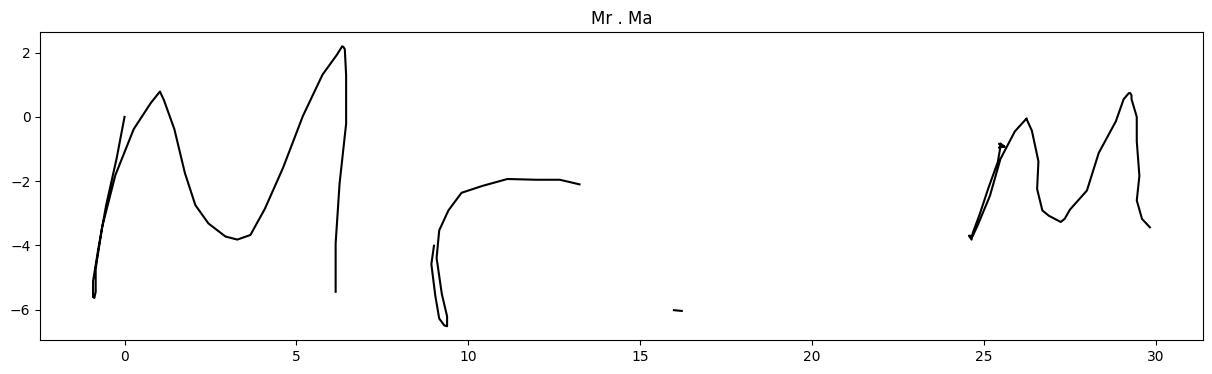

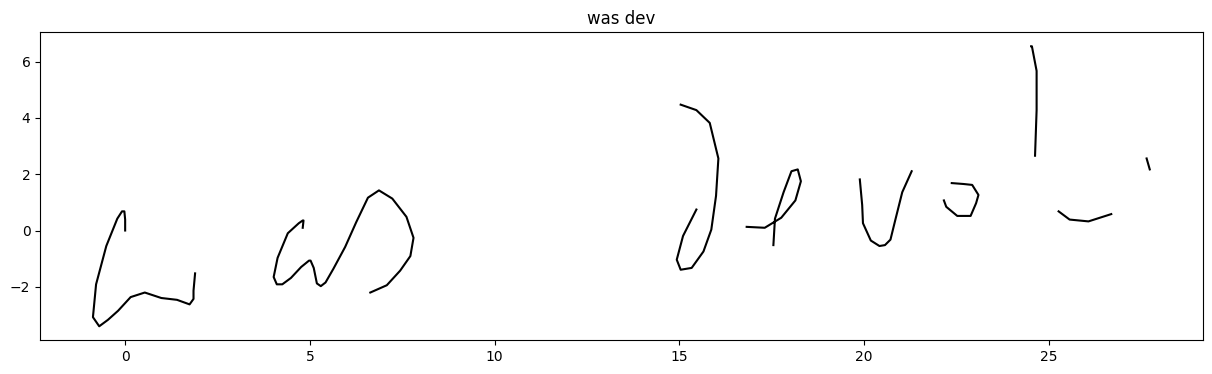

In [5]:
# Inspect our dataset.  It returns a tuple of stroke offsets and matching ascii strings
# You can see that there isn't an exact match for every subject for strokes to ascii 
# because of the token limit in Transformers
SUB = 3

for s, l in train.batched_onehot_set.take(2).cache():
    plot_stroke(s[0][SUB, :, :], s[1][SUB, :])

In [6]:
# Much of the following code is from the excellent Tensorflow tutorial on Transformers: https://www.tensorflow.org/text/tutorials/transformer

# STEP 1 - Positional Embeddings from the original paper. Although, you can also just add a randomized vector and I may try that next
# TODO: Switch to a random vector and see if performance suffers vs this complex embedding.

def get_angles(pos, i, d_model):
  angle_rates = 1 / jnp.power(10000, (2 * (i//2)) / jnp.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(jnp.arange(position)[:, jnp.newaxis],
                          jnp.arange(d_model)[jnp.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads = angle_rads.at[:, 0::2].set(jnp.sin(angle_rads[:, 0::2]))

  # apply cos to odd indices in the array; 2i+1
  angle_rads = angle_rads.at[:, 1::2].set(jnp.cos(angle_rads[:, 1::2]))

  pos_encoding = angle_rads[jnp.newaxis, ...]

  return pos_encoding

In [7]:
# Build up some pieces in haiku. See: https://github.com/deepmind/dm-haiku/tree/main/examples/transformer

def layer_norm(x: jnp.ndarray) -> jnp.ndarray:
  """Applies a unique LayerNorm to x with default settings."""
  ln = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
  return ln(x)

def point_wise_feed_forward(x: jnp.ndarray, d_model: int, dff: int) -> jnp.ndarray:
  mlp = hk.Sequential([
      hk.Linear(dff, name='Lin1'), jax.nn.relu, # (batch_size, seq_len, dff)
      hk.Linear(d_model, name='Lin2'),          # (batch_size, seq_len, d_model)
  ])
  return mlp(x)

In [8]:
# Test out the point_wise_feed_forward network
network = hk.transform(point_wise_feed_forward)
params = network.init(rng=jax.random.PRNGKey(42), x=jnp.zeros((32, 100)), d_model=128, dff=128)

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


In [9]:
# The Encoder - Self attention over the input characters - The only mask needed is padded characters
class Encoder_Layer(hk.Module):
    # The Encoder Layer is one stack of the Encoder, putting the multihead together 
    # with the point wise network and some normalization layers
    def __init__(self, key_size, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__(name='EncoderLayer')

        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        # In haiku the key_size is specified manually instead of d_model/num_heads. Internally, it 
        # will project Q, K, and V to dimensions (*leading_dims, num_heads, head_size) before 
        # computing attention logits. After that you can futher modify it to project to d_model.
        # TODO: Define an initializer here?
        self.mha = hk.MultiHeadAttention(num_heads=num_heads, key_size=key_size, model_size=d_model, w_init_scale=1)

    # I don't think haiku has any method for dealing with removing dropout automatically, so we will need
    # to always pass in a training flag to remove it if necessary during inference
    def __call__(
        self,
        x: jnp.ndarray,
        mask,
        training=True
    ) -> jnp.ndarray:
        # Need to format the mask properly across q_vals * k_vals
        mask1 = mask[:, None, :, None] 
        mask2 = mask[:, None, None, :] 
        mask = mask1 & mask2  # [B, H=1, T, T]

        attn_out = self.mha(x, x, x, mask)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)

        # residual 1
        attn_out = x + attn_out
        attn_out = layer_norm(attn_out)

        attn_out = point_wise_feed_forward(attn_out, self.d_model, self.dff)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)
        
        # residual 2
        attn_out = x + attn_out
        attn_out = layer_norm(attn_out)

        return attn_out

# The Encoder module handles the pre-processing of the character data - embedding + positional encoding
# and looping over the requested number of encoder attention layers
class Encoder(hk.Module):
    def __init__(self, num_layers, key_size, d_model, num_heads, dff, maximum_positional_encoding, 
        dropout_rate=0.1):
        super().__init__(name='Encoder')

        self.num_layers = num_layers
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.enc_layers = [Encoder_Layer(key_size, d_model, num_heads, dff, dropout_rate) 
                       for _ in range(num_layers)]

        # Postional encodings - enocodings are static in this case and not learned parameters
        # TODO: Compare this to random
        self.positional_embeddings = positional_encoding(maximum_positional_encoding, d_model)

    def __call__(
        self,
        x: jnp.ndarray,
        mask,
        training=True
    ) -> jnp.ndarray:
        # The mask for the encoder needs to be broadcastable to the last 2 dimensions (1, 1, T, T)
        # because the multihead attention is parallel - See https://www.tensorflow.org/text/tutorials/transformer
        
        seq_len = jnp.shape(x)[1]
        
        # We are using one-hot encoded characters and not embedded words, so we will just use a
        # prenet to connect that to our model of depth d_model instead
        x = hk.Linear(self.d_model, name='prenet')(x)

        x = x + self.positional_embeddings[:, :seq_len, :]

        if training:
            x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask, training)

        return x

In [10]:
# Test Encoder - x input will be [B, T, d_model] embedded characters with positional encoding added
x=s[1].numpy()

mask = jnp.equal(jnp.sum(x, -1), 0)

def encoder(x: jnp.ndarray, mask: jnp.ndarray) -> jnp.ndarray:
    enc = Encoder(4, 32, 128, 4, 128, 200)

    return enc(x, mask)

network = hk.transform(encoder)
key = jax.random.PRNGKey(42) 
params = network.init(rng=key, x=jnp.ones((32, 7, 101)), mask=mask)

out = network.apply(params, key, x=x, mask=mask)

#params

In [11]:
# The Decoder - Very similar to the Encoder with a self-attention mechanism, but there is a second cross-attention mechanism with
# the output of the Encoder as K, V and the outputs of the self-attention mechanism as Q. That is, as the Decoder attemps to draw
# hand written text based on the Encoder characters, it asks what parts of the encoding are important. Hopefully it learns this 
# relationship and we should see that reflected in the attention weights. It uses additional causal-masking to prevent future tokens
# from being attended to as it attempts to predict the next token.

class Decoder_Layer(hk.Module):
    # The Decoder Layer is one stack of the Decoder, putting the 2 multihead attention blocks together 
    # with the point wise network and some normalization layers
    def __init__(self, key_size, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__(name='DecoderLayer')

        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.mha_self = hk.MultiHeadAttention(num_heads=num_heads, key_size=key_size, model_size=d_model, w_init_scale=1)
        self.mha_cross = hk.MultiHeadAttention(num_heads=num_heads, key_size=key_size, model_size=d_model, w_init_scale=1)

    # Mask here will only deal with the padding mask. We will compute the causal mask as needed in the calling function
    def __call__(
        self,
        x: jnp.ndarray,
        enc_output: jnp.ndarray,
        mask,       # Mask of stroke padding
        enc_mask,   # Mask of character padding
        training=True
    ) -> jnp.ndarray:
        seq_len = jnp.shape(x)[1]

        # Need to format the mask properly across q_vals * k_vals
        mask1 = mask[:, None, :, None] 
        mask2 = mask[:, None, None, :] 
        mask2 = mask1 & mask2  # [B, H=1, T, T]

        # Compute the causal mask and combine with the padding mask for the strokes
        causal_mask = np.tril(np.ones((1, 1, seq_len, seq_len)))  # [B=1, H=1, T, T]
        self_mask = mask2 * causal_mask  # [B, H=1, T, T]

        # Self-attention
        attn_out = self.mha_self(x, x, x, self_mask)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)

        # residual 1
        attn_out = x + attn_out
        attn_out = layer_norm(attn_out)

        # Cross-attention
        # Combine the 2 padding masks. We don't need to attend to encodings that are padded or 
        # query decodings that are padded

        # Need to format the mask properly across q_vals * k_vals
        # TODO: This code is repeated a lot. This needs to be refactored.
        mask1 = mask[:, None, :, None] 
        mask2 = enc_mask[:, None, None, :] 
        cross_mask = mask1 & mask2  # [B, H=1, T, T]
        attn_out = self.mha_cross(attn_out, enc_output, enc_output, cross_mask)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)

        # residual 2
        attn_out = x + attn_out
        attn_out = layer_norm(attn_out)

        attn_out = point_wise_feed_forward(attn_out, self.d_model, self.dff)
        if training:
            attn_out = hk.dropout(hk.next_rng_key(), self.dropout_rate, attn_out)
        
        # residual 3
        attn_out = x + attn_out
        attn_out = layer_norm(attn_out)

        # TODO: It looks like the haiku transformer does not allow the return of the attent weights,
        # only the final projection. I am going to fork my own repo and add that (maybe pull request as well)
        return attn_out

def decoder_prenet(x: jnp.ndarray, d_model: int) -> jnp.ndarray:
  mlp = hk.Sequential([
      hk.Linear(d_model, name='D_Prenet1'), jax.nn.relu,    # (batch_size, seq_len, d_model)
      hk.Linear(d_model, name='D_Prenet2'), jax.nn.relu,   # (batch_size, seq_len, d_model)
      hk.Linear(d_model, name='D_Prenet3')                 # (batch_size, seq_len, d_model)
  ])
  return mlp(x)

# The Decoder module handles the pre-processing of the stroke data - embedding + positional encoding
# and looping over the requested number of decoder attention layers
class Decoder(hk.Module):
    def __init__(self, num_layers, key_size, d_model, num_heads, dff, maximum_positional_encoding, 
        dropout_rate=0.1):
        super().__init__(name='Decoder')

        self.num_layers = num_layers
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.dec_layers = [Decoder_Layer(key_size, d_model, num_heads, dff, dropout_rate) 
                       for _ in range(num_layers)]

        # Postional encodings - enocodings are static in this case and not learned parameters
        # TODO: Compare this to random
        self.positional_embeddings = positional_encoding(maximum_positional_encoding, d_model)

    def __call__(
        self,
        x: jnp.ndarray,
        enc_output: jnp.ndarray,
        enc_mask,
        training=True
    ) -> jnp.ndarray:
        # The mask for the encoder needs to be broadcastable to the last 2 dimensions (1, 1, T, T)
        # because the multihead attention is parallel - See https://www.tensorflow.org/text/tutorials/transformer
        # TODO: padding_value should be passed in or made global
        mask = jnp.equal(jnp.sum(x, -1), train.padding_value*3)

        seq_len = jnp.shape(x)[1]
        
        # Adding a small MLP here to give the network an opportunity to construct filters and non-linear relationships
        # among the raw stroke data
        x = decoder_prenet(x, self.d_model)

        x = x + self.positional_embeddings[:, :seq_len, :]

        if training:
            x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, mask, enc_mask, training)

        return x

In [12]:
# Test Decoder - x input will be [B, T, d_model] embedded characters with positional encoding added
x=s[1].numpy()

mask = jnp.equal(jnp.sum(x, -1), 0)

x=s[0].numpy()

def decoder(x: jnp.ndarray, enc_output: jnp.ndarray, enc_mask: jnp.ndarray) -> jnp.ndarray:
    dec = Decoder(4, 32, 128, 4, 128, 200)

    return dec(x, enc_output, mask)

network = hk.transform(decoder)
key = jax.random.PRNGKey(42) 
params = network.init(rng=key, x=jnp.ones((32, 100, 3)), enc_output=out, enc_mask=mask)

out2 = network.apply(params, key, x=x, enc_output=out, enc_mask=mask)

out2.shape

(32, 100, 128)

In [13]:
# The Writing Transformer

# Output space - number of parameters in the mixture model
NUM_MIX_COM = 20
# weights + means (x + y) + std. devs. (x + y) + correlations + end_of_stroke
# Unlike the Mixture Density Network notebook we are going to add cross correlation
# terms to our loss and sampling functions for added complexity of the density 
# estimations
NUM_PARAMS = NUM_MIX_COM + NUM_MIX_COM*2 + NUM_MIX_COM*2 + NUM_MIX_COM + 1

class Writing_Transformer(hk.Module):
    def __init__(self, num_layers, key_size, d_model, num_heads, dff, pe_encoding, pe_target, 
        dropout_rate=0.1):
        super().__init__(name='Writing_Transformer')

        self.num_layers = num_layers
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.enc = Encoder(num_layers, key_size, d_model, num_heads, dff, pe_encoding, dropout_rate)
        self.dec = Decoder(num_layers, key_size, d_model, num_heads, dff, pe_target, dropout_rate)

    def __call__(
        self,
        inp: jnp.ndarray,
        tar: jnp.ndarray,
        training=True
    ) -> jnp.ndarray:
        enc_mask = jnp.equal(jnp.sum(inp, -1), 0)

        # The Encoder
        enc_output = self.enc(inp, enc_mask, training)

        # The Decoder
        dec_output = self.dec(tar, enc_output, enc_mask, training)

        # The final layer to give us our logits
        x = hk.Linear(NUM_PARAMS, name='final_layer')(dec_output)

        return x

In [14]:
# Test The full network
inp=s[1].numpy()
tar=s[0].numpy()

def writing_transformer(inp: jnp.ndarray, tar: jnp.ndarray) -> jnp.ndarray:
    tra = Writing_Transformer(4, 32, 128, 4, 128, 200, 1000, 0.2)

    return tra(inp, tar)

network = hk.transform(writing_transformer)
key = jax.random.PRNGKey(42) 
params = network.init(rng=key, inp=inp, tar=tar)

out3 = network.apply(params, key, inp=inp, tar=tar)

out3.shape

(32, 100, 121)

In [20]:
# Now for the loss function
# TODO: I think there are a lot of edge cases here that will result in NaNs when training.

EPS = 0.000001

@jax.jit
def my_loss_fun_MDN(params: hk.Params, batch: tuple) -> jnp.ndarray:
    # Predict the next strokes
    key = jax.random.PRNGKey(42) 

    y_true = batch[0]

    logits = network.apply(params, key, batch[1], y_true)

    pis, mu, sig, rho, eos = jnp.array_split(logits, [NUM_MIX_COM, NUM_MIX_COM*3, NUM_MIX_COM*5, NUM_MIX_COM*6], axis=-1)
    
    #print(eos.shape)

    # weights - must be a probability distribution so softmax over all components
    pis = jax.nn.softmax(pis)
    
    # means - no transformation needed
    mu_x1, mu_x2 = jnp.array_split(mu, 2, axis=-1)
    
    # standard deviations - must be strictly positive so exponent
    sig = jnp.exp(sig)
    
    sig = jnp.clip(sig, EPS, np.inf)
    
    sig_x1, sig_x2 = jnp.array_split(sig, 2, axis=-1)
    
    x1, x2, eos_true = jnp.array_split(y_true, 3, axis=-1)
    
    eos_true = jnp.squeeze(eos_true)
        
    # correlations - squish to -1 to 1 with tanh activation
    rho = jnp.tanh(rho)
    
    rho = jnp.clip(rho, -1.+EPS, 1.-EPS)
    
    # Define Z as in Graves, 2013
    Z = jnp.square( ( x1-mu_x1 ) / sig_x1 ) + jnp.square( ( x2-mu_x2 ) / sig_x2 ) - ( 2 * rho * (x1-mu_x1) * (x2-mu_x2) ) / ( sig_x1*sig_x2 )
    
    one_minus_rho_square = 1. - jnp.square(rho)
    
    # Now form Gaussian mixtures
    term1 = jnp.divide(1., ( 2. * np.pi * sig_x1 * sig_x2 * jnp.sqrt( one_minus_rho_square ) ))
    term2 = jnp.exp( jnp.divide ( (-1. * Z) , (2.*( one_minus_rho_square )) ))
    
    mix_loss = jnp.sum(pis * term1 * term2, axis=-1)       
    
    mix_loss = jnp.clip(mix_loss, EPS, np.inf)

    # end of stroke loss
    eos = jnp.squeeze(jax.nn.sigmoid(eos))
    
    eos = jnp.clip(eos, EPS, 1.-EPS)
    
    eos_loss = jnp.where(jnp.equal(eos_true, 1.), eos, 1.-eos)
    
    # Only the valid parts of the sequence should count towards the loss.  The invalid parts are tagged with -2200
    val_seq = jnp.squeeze(jnp.not_equal(eos_true, train.padding_value))

    # This is the total loss for each element (batch * num_timepoints)
    tot_loss = -(jnp.log(mix_loss) + jnp.log(eos_loss))

    # The sequence loss is the sum of only the valid timepoints
    
    tot_loss = jnp.where(val_seq, tot_loss, 0.)   
    
    seq_tot = jnp.sum(val_seq, axis=-1)

    #seq_tot = tf.cast(seq_tot, tf.float32)

    tot_loss = jnp.sum(tot_loss, axis=-1) / seq_tot   

    return jnp.mean(tot_loss)

In [21]:
# Test out the loss function
data = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()

out4 = my_loss_fun_MDN(params, data.next()[0])

out4

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


DeviceArray(-3.5021067, dtype=float32)

In [22]:
# Training
EPOCHS = 1

learning_rate = 0.001

num_layers = 2
key_size = 32
d_model = 128
dff = 256
num_heads = 4
dropout_rate = 0.1

def writing_transformer(inp: jnp.ndarray, tar: jnp.ndarray) -> jnp.ndarray:
    tra = Writing_Transformer(num_layers, key_size, d_model, num_heads, dff, pe_encoding=250, pe_target=1000, dropout_rate=dropout_rate)

    return tra(inp, tar)

network = hk.transform(writing_transformer)
optimiser = optax.adam(learning_rate)

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, batch: tuple):
  grad = jax.grad(my_loss_fun_MDN)(params, batch)
  updates, opt_state = optimiser.update(grad, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state

# TODO: make fetching the iterator more elegant and does the conversion from numpy to jax slow things down?
#b = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()
key = jax.random.PRNGKey(42) 
#s = next(b)[0]
params = network.init(rng=key, inp=inp, tar=tar)
opt_state = optimiser.init(params)

train_loss = tf.keras.metrics.Mean(name='train_loss')

for step in range(EPOCHS):
  data_iter = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()

  train_loss.reset_states()

  print({"Epoch": step})
  for (batch, (b, _)) in enumerate(data_iter):
    params, opt_state = update(params, opt_state, b)

    loss = my_loss_fun_MDN(params, b)
    train_loss(loss)

    if batch % 50 == 0:
      print(f'Epoch {step + 1} Batch {batch} Loss {train_loss.result():.4f}')

  # Average loss?
  #data_iter = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()
  #total_loss = 0
  #for b, _ in data_iter:
  #  total_loss = total_loss + my_loss_fun_MDN(params, b)

  #print("   loss {:0.4f}".format(total_loss*BATCH/20000))

{'Epoch': 0}
Epoch 1 Batch 0 Loss 3.1082
Epoch 1 Batch 50 Loss 0.6695
Epoch 1 Batch 100 Loss -0.1676
Epoch 1 Batch 150 Loss -0.6086
Epoch 1 Batch 200 Loss -0.9952
Epoch 1 Batch 250 Loss -1.2817
Epoch 1 Batch 300 Loss -1.5474
Epoch 1 Batch 350 Loss -1.7339


In [94]:
# We also need our own sampling function in this case
from tensorflow_probability.substrates import jax as tfp

# sample the mixture model
# input: res (mixture_components)
#        b (temperature)
# output: sample, pis, mean, variance
def sample_mix_model(res, b):
      #print(res.shape)
      pis, mu, sig, rho, eos = jnp.array_split(res, [NUM_MIX_COM, NUM_MIX_COM*3, NUM_MIX_COM*5, NUM_MIX_COM*6], axis=-1)

      # weights - must be a probability distribution so softmax over all components
      pis = jax.nn.softmax(pis * (1+b))

      # means - no transformation needed
      mu_x1, mu_x2 = jnp.array_split(mu, 2, axis=-1)
      
      # standard deviations - must be strictly positive so exponent
      sig = jnp.exp(sig - b)
      
      print(sig.shape)

      sig_x1, sig_x2 = jnp.array_split(sig, 2, axis=-1)
            
      # correlations - squish to -1 to 1 with tanh activation
      rho = jnp.tanh(rho)

      S = jax.numpy.diag(jnp.stack([sig_x1, sig_x2], axis=-1))

      #E = jnp.eye(2, batch_shape=[NUM_MIX_COM])
      E = jnp.repeat(jnp.eye(2)[None, :], NUM_MIX_COM, axis=0)

      rho_exp = jnp.reshape(jnp.repeat(rho, 4), [NUM_MIX_COM, 2, 2])
    
      corr_mat = jnp.where(jnp.equal(E, 1.), E, rho_exp)
      
      cov_mat = jnp.matmul(S, corr_mat)
      cov_mat = jnp.matmul(cov_mat, S)

      # The distribution is a mixture of gaussians
      gm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=pis),
            components_distribution=tfp.distributions.MultivariateNormalTriL(loc=tf.stack([mu_x1, mu_x2], axis=-1),
                                                                    scale_tril=tf.linalg.cholesky(cov_mat)))

      # End of stroke
      eos = jax.nn.sigmoid(eos)
      
      bd = tfp.distributions.Bernoulli(probs=eos)
      
      bd_samp = bd.sample(seed=jax.random.PRNGKey(seed=42))
      
      #print(tf.concat([gm.sample(), eos], axis=-1))
      
      gm_samp = gm.sample(seed=jax.random.PRNGKey(seed=42))

      return np.hstack((gm_samp.numpy(), bd_samp.numpy(), gm.mean().numpy(), gm.covariance().numpy().ravel(), pis))

In [65]:
# Now we need an evaluate function that will take in a character sequence and 
# generate some writing

# Convert a sentence to a one-hot-encoded vector
def convert_sentence(sentence):
  # Convert it to a one-hot encoded vector for the encoder
  U_conv = tf.keras.backend.one_hot(train.text_to_int(sentence), len(train.vocab)+1)
  #U_conv = train.text_to_int(sentence)
  # Pad it to match the original data that was input into the encoder
  U_conv = tf.keras.preprocessing.sequence.pad_sequences([U_conv],
                                                         maxlen=train.MAX_CHAR_SEQ_LEN,
                                                         padding='post',
                                                         value=train.char_padding_value);
  #U_conv = tf.convert_to_tensor(U_conv, dtype='float32')

  return U_conv

In [30]:
encoding_sent = 'Hello'

one_hot_sentence = convert_sentence(encoding_sent)

one_hot_sentence.shape

(1, 7, 101)

In [95]:
import matplotlib.animation as animation

output_name = "test_attention.mp4"

b = 10.0

def evaluate(U_conv):
  #gen_sequence = np.zeros((1, 3))

  dec_input = jnp.zeros((1, 1, 3))

  MAX_LEN = 100

 # transformer.reset_states()

  #fig = plt.figure(figsize=(10, 10))

 # ims = []

#  for t in range(int(train.MAX_STROKE_LEN)):
  for t in range(int(MAX_LEN)):
    # Create masks.  Even in the inference stage we may create input that is 
    # padded, such as the one-hot_sentence, and we always need a look-ahead 
    # mask
    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(U_conv, dec_input)

    key = jax.random.PRNGKey(42) 

    predictions_all = network.apply(params, key, U_conv, dec_input)

    #predictions_all = transformer(U_conv,
    #                                                     dec_input,
     #                                                    False,
     #                                                    enc_padding_mask,
     #                                                    combined_mask,
     #                                                    dec_padding_mask)

    #data = tf.squeeze(attention_weights['decoder_layer1_block2'], 0)[0]
  
    #data_all = np.zeros((MAX_LEN, 20))

    #data_all[:data.shape[0], :] = data

    #ax = fig.add_subplot(1, 1, 1)
    #im = plt.imshow(data_all, cmap='viridis', interpolation='nearest', aspect='auto', animated=True)

    #ax = plt.gca()

    #labels = 'Eye tracking....'

    #ax.set_xticks(range(0, train.MAX_CHAR_SEQ_LEN-1))
    #ax.set_xticklabels(labels)

    #ax.set_xlabel('Characters to be Written')
    #ax.set_ylabel('Stroke Number')

    #ims.append([im])

    predictions = sample_mix_model(predictions_all[0, -1, :], b)

    pred_strokes = predictions[:3]

    pred_strokes = pred_strokes[np.newaxis, np.newaxis, :]

    print(pred_strokes)

    #gen_sequence = np.append(gen_sequence, np.expand_dims(pred_strokes, 0), 0)

    #print(pred_strokes.shape)

    #dec_input = tf.expand_dims([pred_strokes], 0)
    #dec_input = tf.concat([dec_input, pred_strokes], axis=1)

    #print(dec_input.shape)

  #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
   #                             repeat_delay=1000)
  
  #ani.save(output_name)

  #plt.show()

  #return dec_input.numpy(), attention_weights
  return dec_input

In [96]:
evaluate(one_hot_sentence)

/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/don/mltests-venv/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


(2, 20)
(20, 2, 2)
(20,)


InvalidArgumentError: {{function_node __wrapped__Cholesky_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input must have rank >= 2, got 1 [Op:Cholesky]

In [101]:
tf.stack([[1, 1, 1, 1, 1], [2, 2, 2, 1, 1]], axis=-1)

<tf.Tensor: shape=(5, 2), dtype=int32, numpy=
array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 1],
       [1, 1]], dtype=int32)>